# TOP5 따릉이 대여소 이동패턴 분석 (6개월 데이터)

## 목표
- TOP5 인기 대여소에서 대여한 이용객들의 반납 장소 패턴 분석
- 순환형 vs 이동형 이용 패턴 파악
- 6개월 데이터로 분석 속도 향상

### TOP5 대여소
1. 207번 - 여의나루역 1번출구 앞
2. 4217번 - 한강공원 망원나들목
3. 3515번 - 서울숲 관리사무소
4. 502번 - 자양(뚝섬한강공원)역 1번출구 앞
5. 474번 - 동대문역사문화공원역 1번출구 뒤편

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rcParams
import warnings
import os

warnings.filterwarnings('ignore')
print('라이브러리 로드 완료')


라이브러리 로드 완료


In [2]:
# 한글 폰트 설정
def setup_korean_font():
    font_paths = [
        r'C:\Windows\Fonts\malgun.ttf',
        r'C:\Windows\Fonts\gulim.ttc',
        r'C:\Windows\Fonts\batang.ttc'
    ]
    
    for font_path in font_paths:
        if os.path.exists(font_path):
            try:
                korean_font = fm.FontProperties(fname=font_path)
                fm.fontManager.addfont(font_path)
                plt.rcParams['font.family'] = korean_font.get_name()
                plt.rcParams['axes.unicode_minus'] = False
                print(f'한글 폰트 설정: {korean_font.get_name()}')
                return korean_font
            except:
                continue
    return None

korean_font_prop = setup_korean_font()
sns.set_style('whitegrid')


한글 폰트 설정: Malgun Gothic


In [3]:
# TOP5 대여소 정보
top5_stations = {
    '207': '여의나루역 1번출구 앞',
    '4217': '한강공원 망원나들목',
    '3515': '서울숲 관리사무소',
    '502': '자양(뚝섬한강공원)역 1번출구 앞',
    '474': '동대문역사문화공원역 1번출구 뒤편'
}

print('TOP5 대여소:')
for station_id, station_name in top5_stations.items():
    print(f'  {station_id}번: {station_name}')


TOP5 대여소:
  207번: 여의나루역 1번출구 앞
  4217번: 한강공원 망원나들목
  3515번: 서울숲 관리사무소
  502번: 자양(뚝섬한강공원)역 1번출구 앞
  474번: 동대문역사문화공원역 1번출구 뒤편


In [4]:
# 데이터 파일 경로 - 6개월치만 사용
import glob

# 실제 파일 경로 찾기
actual_files = glob.glob('../서울특별시 공공자전거 대여이력 정보_24*.csv')
actual_files.sort()

print('실제 존재하는 파일들:')
for f in actual_files:
    print(f'  {f}')

# 6개월치 파일 리스트 (1-6월)
data_files = actual_files if actual_files else [
    '../서울특별시 공공자전거 대여이력 정보_2401.csv',
    '../서울특별시 공공자전거 대여이력 정보_2402.csv',
    '../서울특별시 공공자전거 대여이력 정보_2403.csv',
    '../서울특별시 공공자전거 대여이력 정보_2404.csv',
    '../서울특별시 공공자전거 대여이력 정보_2405.csv',
    '../서울특별시 공공자전거 대여이력 정보_2406.csv'
]

# 6개월치만 사용
data_files = data_files[:6]

print(f'\n사용할 파일: {len(data_files)}개 (6개월치)')

# 각 파일 존재 여부와 구조 확인
valid_files = []
for file_path in data_files:
    try:
        # 파일 존재 및 읽기 테스트
        test_df = pd.read_csv(file_path, encoding='cp949', nrows=1)
        print(f'✅ {file_path} - OK')
        valid_files.append(file_path)
    except FileNotFoundError:
        print(f'❌ {file_path} - 파일 없음')
    except Exception as e:
        print(f'⚠️ {file_path} - 오류: {e}')

print(f'\n사용 가능한 파일: {len(valid_files)}개')
data_files = valid_files


실제 존재하는 파일들:
  ..\서울특별시 공공자전거 대여이력 정보_2401.csv
  ..\서울특별시 공공자전거 대여이력 정보_2402.csv
  ..\서울특별시 공공자전거 대여이력 정보_2403.csv
  ..\서울특별시 공공자전거 대여이력 정보_2404.csv
  ..\서울특별시 공공자전거 대여이력 정보_2405.csv
  ..\서울특별시 공공자전거 대여이력 정보_2406.csv
  ..\서울특별시 공공자전거 대여이력 정보_2407.csv
  ..\서울특별시 공공자전거 대여이력 정보_2408.csv
  ..\서울특별시 공공자전거 대여이력 정보_2409.csv
  ..\서울특별시 공공자전거 대여이력 정보_2410.csv
  ..\서울특별시 공공자전거 대여이력 정보_2411.csv
  ..\서울특별시 공공자전거 대여이력 정보_2412.csv

사용할 파일: 6개 (6개월치)
✅ ..\서울특별시 공공자전거 대여이력 정보_2401.csv - OK
✅ ..\서울특별시 공공자전거 대여이력 정보_2402.csv - OK
✅ ..\서울특별시 공공자전거 대여이력 정보_2403.csv - OK
✅ ..\서울특별시 공공자전거 대여이력 정보_2404.csv - OK
✅ ..\서울특별시 공공자전거 대여이력 정보_2405.csv - OK
✅ ..\서울특별시 공공자전거 대여이력 정보_2406.csv - OK

사용 가능한 파일: 6개


In [5]:
# TOP5 대여소 데이터 수집 - 디버깅 강화
all_data = []

# 파일별 월 번호 매핑 (파일명에서 월 추출)
def get_month_from_filename(filename):
    import re
    match = re.search(r'_24(\d{2})\.csv', filename)
    return int(match.group(1)) if match else 0

# 먼저 실제 데이터를 샘플로 확인
print('=== 실제 데이터 구조 확인 ===')
sample_file = data_files[0]  # 1월 파일
try:
    sample_df = pd.read_csv(sample_file, encoding='cp949', nrows=1000)
    print(f'샘플 파일: {sample_file}')
    print(f'컬럼: {list(sample_df.columns)}')
    
    # 대여소 번호 컬럼 찾기
    rental_col = None
    for col in sample_df.columns:
        if '대여' in col and '대여소번호' in col:
            rental_col = col
            break
    
    if rental_col:
        print(f'대여소번호 컬럼: {rental_col}')
        sample_ids = sample_df[rental_col].head(20).tolist()
        print(f'실제 대여소번호 샘플: {sample_ids}')
        
        # TOP5 ID들이 실제로 존재하는지 확인
        print(f'\nTOP5 ID 존재 확인:')
        for station_id in ['207', '4217', '3515', '502', '474']:
            count = len(sample_df[sample_df[rental_col] == station_id])
            print(f'  {station_id}: {count}건')
            
            # 0패딩 버전도 확인
            padded_count = len(sample_df[sample_df[rental_col] == f'0{station_id}'])
            if padded_count > 0:
                print(f'  0{station_id}: {padded_count}건')
                
            padded2_count = len(sample_df[sample_df[rental_col] == f'00{station_id}'])
            if padded2_count > 0:
                print(f'  00{station_id}: {padded2_count}건')
except Exception as e:
    print(f'샘플 파일 읽기 오류: {e}')

# 실제 데이터 수집
for file_path in data_files:
    month = get_month_from_filename(file_path)
    print(f'\n{month}월 데이터 처리: {file_path}')
    
    try:
        df = pd.read_csv(file_path, encoding='cp949')
        print(f'  파일 로드: {len(df):,}건')
        
        # 컬럼명 확인 및 표준화
        rental_col = None
        return_col = None
        
        # 대여소 번호 컬럼 찾기
        for col in df.columns:
            if '대여' in col and '대여소번호' in col:
                rental_col = col
                break
        
        # 반납소 번호 컬럼 찾기  
        for col in df.columns:
            if '반납' in col and '번호' in col:
                return_col = col
                break
        
        print(f'  탐지된 컬럼 - 대여: {rental_col}, 반납: {return_col}')
        
        if not rental_col or not return_col:
            print(f'  ❌ 필요한 컬럼 없음')
            continue
        
        # 데이터 타입 변환
        df[rental_col] = df[rental_col].astype(str)
        df[return_col] = df[return_col].astype(str)
        
        # 실제 TOP5 대여소 번호 형태 확인
        print(f'  실제 대여소번호 샘플: {df[rental_col].head(5).tolist()}')
        
        # TOP5 각각에 대해 다양한 형태로 검색
        found_data = []
        for base_id in ['207', '4217', '3515', '502', '474']:
            # 가능한 모든 형태 시도
            possible_forms = [base_id, f'0{base_id}', f'00{base_id}', f'000{base_id}']
            
            station_data = None
            for form in possible_forms:
                temp_data = df[df[rental_col] == form]
                if len(temp_data) > 0:
                    print(f'    {base_id}번 → {form} 형태로 {len(temp_data):,}건 발견')
                    # 표준 ID로 변환
                    temp_data = temp_data.copy()
                    temp_data[rental_col] = base_id  # 표준 ID로 통일
                    station_data = temp_data
                    break
            
            if station_data is not None:
                found_data.append(station_data)
            else:
                print(f'    {base_id}번: 데이터 없음')
        
        # 발견된 데이터 통합
        if found_data:
            month_data = pd.concat(found_data, ignore_index=True)
            # 컬럼명 표준화
            month_data = month_data.rename(columns={
                rental_col: '대여소번호',
                return_col: '반납소번호'
            })
            month_data['월'] = month
            all_data.append(month_data)
            
            print(f'  ✅ {month}월 TOP5 데이터: {len(month_data):,}건')
            
            # 대여소별 건수 확인
            station_counts = month_data['대여소번호'].value_counts()
            for station_id in ['207', '4217', '3515', '502', '474']:
                count = station_counts.get(station_id, 0)
                if count > 0:
                    print(f'    {station_id}번: {count:,}건')
        else:
            print(f'  ❌ {month}월 TOP5 대여소 데이터 없음')
            
    except Exception as e:
        print(f'  ❌ 오류: {e}')

# 데이터 통합
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f'\n🎯 최종 통합 데이터: {len(combined_df):,}건')
    
    # 대여소별 총 건수
    total_by_station = combined_df['대여소번호'].value_counts()
    print('\n대여소별 총 이용건수 (6개월):')
    for station_id, station_name in top5_stations.items():
        count = total_by_station.get(station_id, 0)
        print(f'  {station_id}번 {station_name}: {count:,}건')
        
    # 반납소번호 샘플 확인
    print(f'\n반납소번호 형태 확인:')
    print(f'샘플: {combined_df["반납소번호"].head(10).tolist()}')
    print(f'고유 반납소 수: {combined_df["반납소번호"].nunique():,}개')
else:
    print('\n❌ 사용할 데이터가 없습니다')
    combined_df = pd.DataFrame()


=== 실제 데이터 구조 확인 ===
샘플 파일: ..\서울특별시 공공자전거 대여이력 정보_2401.csv
컬럼: ['자전거번호', '대여일시', '대여 대여소번호', '대여 대여소명', '대여거치대', '반납일시', '반납대여소번호', '반납대여소명', '반납거치대', '이용시간(분)', '이용거리(M)', '생년', '성별', '이용자종류', '대여대여소ID', '반납대여소ID', '자전거구분']
대여소번호 컬럼: 대여 대여소번호
실제 대여소번호 샘플: [4804, 4169, 540, 1139, 3416, 226, 2389, 3912, 214, 1601, 5768, 3211, 589, 1725, 1038, 1197, 3767, 3502, 108, 3881]

TOP5 ID 존재 확인:
  207: 0건
  4217: 0건
  3515: 0건
  502: 0건
  474: 0건

1월 데이터 처리: ..\서울특별시 공공자전거 대여이력 정보_2401.csv
  파일 로드: 2,053,893건
  탐지된 컬럼 - 대여: 대여 대여소번호, 반납: 반납대여소번호
  실제 대여소번호 샘플: ['4804', '4169', '540', '1139', '3416']
    207번 → 207 형태로 2,300건 발견
    4217번 → 4217 형태로 2,580건 발견
    3515번 → 3515 형태로 413건 발견
    502번 → 502 형태로 3,794건 발견
    474번 → 474 형태로 1,237건 발견
  ✅ 1월 TOP5 데이터: 10,324건
    207번: 2,300건
    4217번: 2,580건
    3515번: 413건
    502번: 3,794건
    474번: 1,237건

2월 데이터 처리: ..\서울특별시 공공자전거 대여이력 정보_2402.csv
  파일 로드: 2,101,129건
  탐지된 컬럼 - 대여: 대여 대여소번호, 반납: 반납대여소번호
  실제 대여소번호 샘플: ['711', '4387', '1022', '2228

In [6]:
# TOP5 대여소별 반납 패턴 분석 - 0패딩 문제 해결
if not combined_df.empty:
    results = {}
    
    # ID 정규화 함수 (패딩 제거)
    def normalize_station_id(station_id):
        return str(int(str(station_id).lstrip('0'))) if str(station_id).isdigit() else str(station_id)
    
    print('=== 디버깅: 데이터 구조 확인 ===')
    print(f'통합 데이터 컬럼: {list(combined_df.columns)}')
    print(f'대여소번호 샘플: {combined_df["대여소번호"].head().tolist()}')
    print(f'반납소번호 샘플: {combined_df["반납소번호"].head().tolist()}')
    
    for station_id, station_name in top5_stations.items():
        print(f'\n{station_id}번 {station_name}')
        print('-' * 40)
        
        # 해당 대여소 데이터 (정규화된 ID로 필터링)
        station_data = combined_df[
            combined_df['대여소번호'].apply(normalize_station_id) == station_id
        ]
        
        if len(station_data) > 0:
            # 반납소번호도 정규화하여 집계
            return_ids_normalized = station_data['반납소번호'].apply(normalize_station_id)
            return_counts = return_ids_normalized.value_counts()
            
            print(f'반납지 종류: {len(return_counts)}개')
            print(f'상위 3개 반납지: {return_counts.head(3).to_dict()}')
            
            # 동일지점 반납 계산 (정규화된 ID로 비교)
            same_station_count = return_counts.get(station_id, 0)
            same_ratio = (same_station_count / len(station_data)) * 100
            
            print(f'총 대여: {len(station_data):,}건')
            print(f'동일지점 반납: {same_station_count:,}건 ({same_ratio:.1f}%)')
            
            # 패턴 분류
            if same_ratio > 70:
                pattern = '순환형'
            elif same_ratio > 40:
                pattern = '혼합형'
            else:
                pattern = '이동형'
            print(f'패턴: {pattern}')
            
            # TOP 5 반납지
            top5_returns = return_counts.head(5)
            print('\nTOP 5 반납지:')
            for rank, (return_id, count) in enumerate(top5_returns.items(), 1):
                ratio = (count / len(station_data)) * 100
                mark = '🔄' if return_id == station_id else ''
                print(f'  {rank}위: {return_id}번 {count:,}건 ({ratio:.1f}%) {mark}')
            
            results[station_id] = {
                'total': len(station_data),
                'same_ratio': same_ratio,
                'pattern': pattern,
                'top_returns': top5_returns,
                'same_count': same_station_count
            }
        else:
            print('데이터 없음')
            results[station_id] = None
else:
    print('분석할 데이터가 없습니다')
    results = {}


=== 디버깅: 데이터 구조 확인 ===
통합 데이터 컬럼: ['자전거번호', '대여일시', '대여소번호', '대여 대여소명', '대여거치대', '반납일시', '반납소번호', '반납대여소명', '반납거치대', '이용시간(분)', '이용거리(M)', '생년', '성별', '이용자종류', '대여대여소ID', '반납대여소ID', '자전거구분', '월']
대여소번호 샘플: ['207', '207', '207', '207', '207']
반납소번호 샘플: ['05860', '04559', '00223', '04574', '04559']

207번 여의나루역 1번출구 앞
----------------------------------------
반납지 종류: 1353개
상위 3개 반납지: {'207': 10741, '4564': 1828, '202': 1713}
총 대여: 50,175건
동일지점 반납: 10,741건 (21.4%)
패턴: 이동형

TOP 5 반납지:
  1위: 207번 10,741건 (21.4%) 🔄
  2위: 4564번 1,828건 (3.6%) 
  3위: 202번 1,713건 (3.4%) 
  4위: 5870번 1,187건 (2.4%) 
  5위: 217번 1,060건 (2.1%) 

4217번 한강공원 망원나들목
----------------------------------------
반납지 종류: 1015개
상위 3개 반납지: {'4217': 18728, '103': 1761, '907': 1618}
총 대여: 73,751건
동일지점 반납: 18,728건 (25.4%)
패턴: 이동형

TOP 5 반납지:
  1위: 4217번 18,728건 (25.4%) 🔄
  2위: 103번 1,761건 (2.4%) 
  3위: 907번 1,618건 (2.2%) 
  4위: 106번 1,365건 (1.9%) 
  5위: 117번 1,335건 (1.8%) 

3515번 서울숲 관리사무소
----------------------------------------
반납지 

대여소 마스터 데이터 로드 완료: 3,388개
매핑 딕셔너리 크기: 3,388개

TOP5 대여소 매핑 확인:
  207번: 서강대역 2번출구 앞...
  4217번: 매핑 없음
  3515번: 매핑 없음
  502번: 서울특별시 강동구 성내동 434-28...
  474번: 불광역 8번출구...


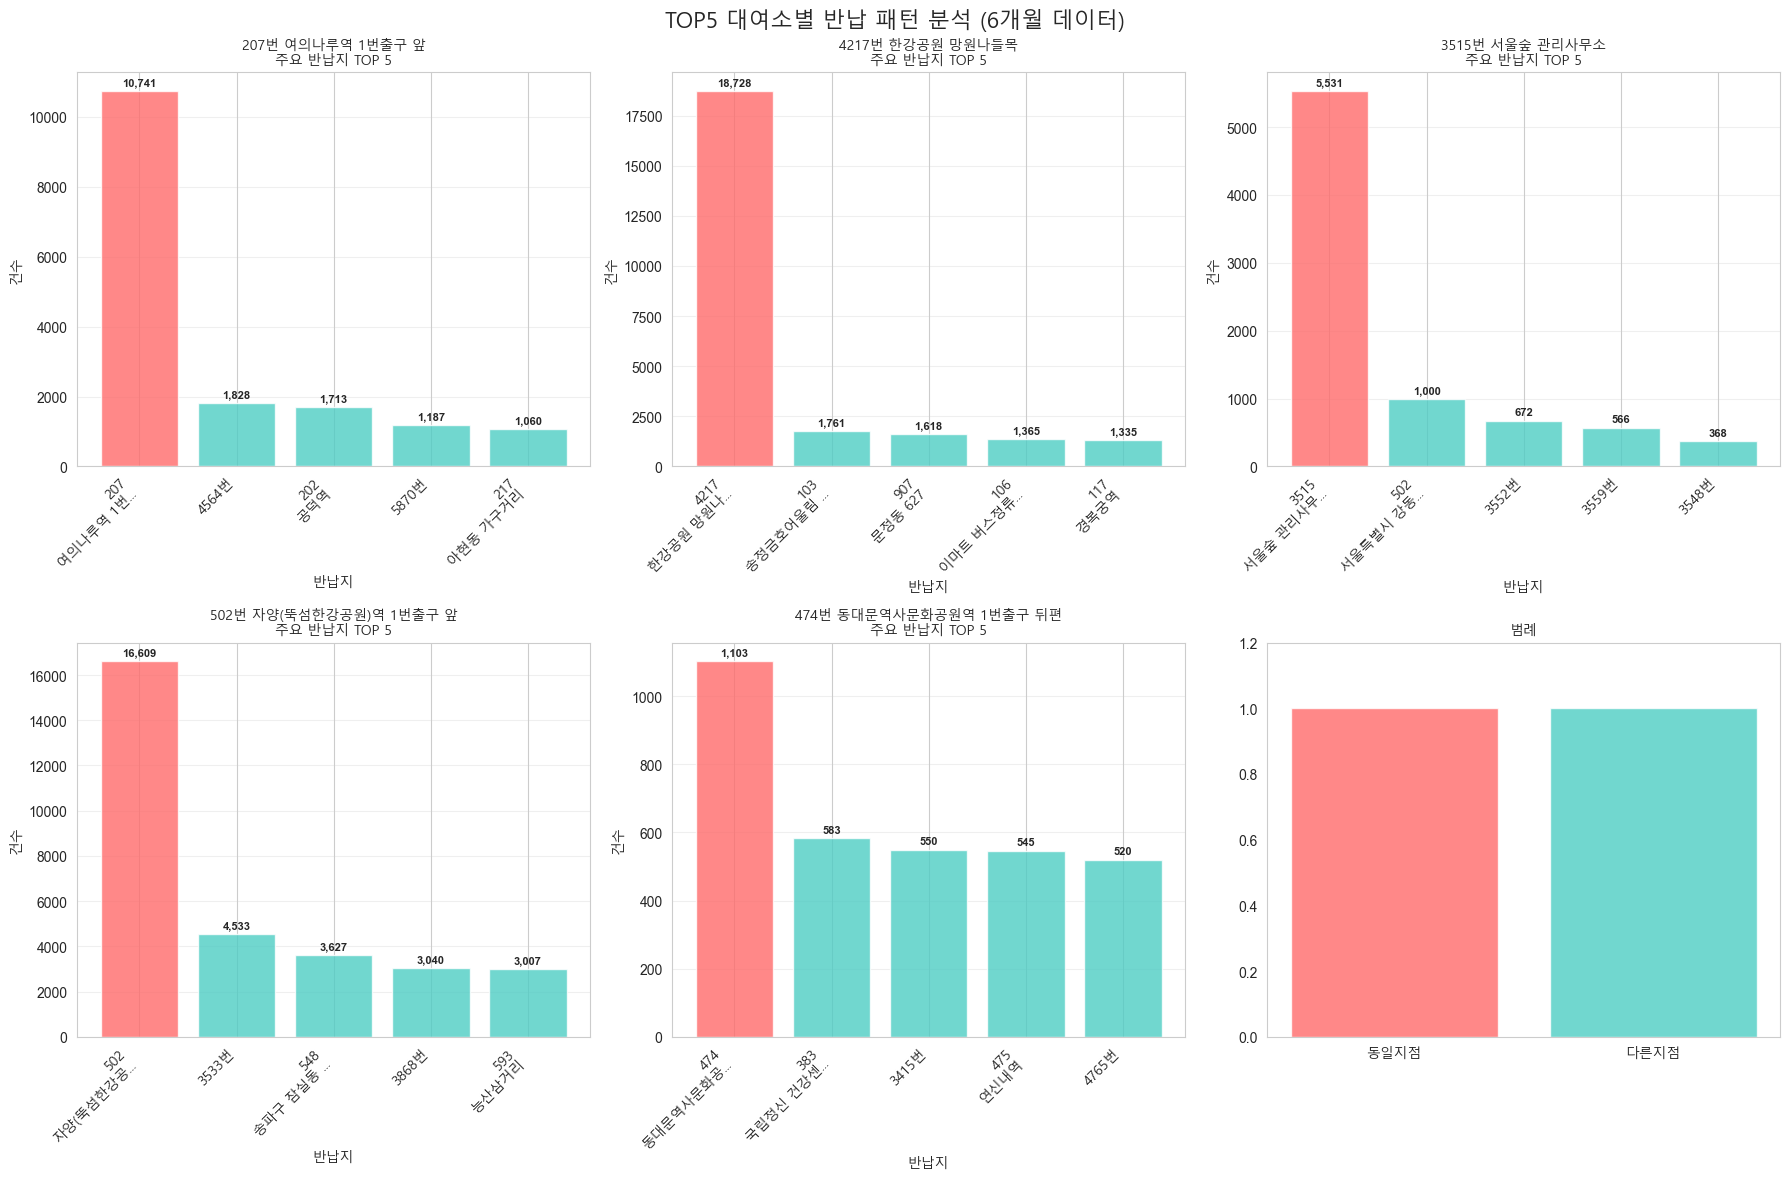

In [7]:
# 대여소 마스터 데이터 로드
try:
    station_master = pd.read_csv(r'C:\Users\SBA\Desktop\데이터분석\따릉이대여소 마스터 정보.csv', encoding='cp949')
    print(f'대여소 마스터 데이터 로드 완료: {len(station_master):,}개')
    
    # 전체 매핑 딕셔너리 생성 (마스터 데이터만 사용)
    station_name_map = {}
    for _, row in station_master.iterrows():
        full_id = str(row['대여소_ID'])
        station_name = row['주소2'] if pd.notna(row['주소2']) and str(row['주소2']).strip() else row['주소1']
        
        if full_id.startswith('ST-'):
            # ST- 제거
            clean_id = full_id.replace('ST-', '')
            station_name_map[clean_id] = station_name
            
            # 앞의 0들을 하나씩 제거한 버전들도 추가
            temp_id = clean_id
            while temp_id.startswith('0') and len(temp_id) > 1:
                temp_id = temp_id[1:]
                if temp_id not in station_name_map:  # 중복 방지
                    station_name_map[temp_id] = station_name
    
    print(f'매핑 딕셔너리 크기: {len(station_name_map):,}개')
    
    # TOP5 매핑 확인
    check_ids = ['207', '4217', '3515', '502', '474']
    print(f'\nTOP5 대여소 매핑 확인:')
    for station_id in check_ids:
        if station_id in station_name_map:
            print(f'  {station_id}번: {station_name_map[station_id][:30]}...')
        else:
            print(f'  {station_id}번: 매핑 없음')
    
except Exception as e:
    print(f'대여소 마스터 데이터 로드 실패: {e}')
    station_name_map = {}

# 시각화 - 한글 폰트 문제 해결 및 대여소명 표시
if 'results' in locals() and any(results.values()):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (station_id, station_name) in enumerate(top5_stations.items()):
        ax = axes[idx]
        
        if results[station_id]:
            data = results[station_id]
            top_returns = data['top_returns']
            
            if len(top_returns) > 0:
                # 데이터 준비 - 대여소명 포함
                labels = []
                counts = top_returns.values
                colors = []
                
                for return_id in top_returns.index:
                    return_id_str = str(return_id)
                    
                    # 대여소명 찾기 (마스터 데이터에 있는 것만)
                    if return_id_str == str(station_id):
                        # 동일지점인 경우 현재 대여소명 사용
                        station_display_name = station_name[:8] + '...' if len(station_name) > 8 else station_name
                        label = f'{return_id}\n{station_display_name}'
                        colors.append('#FF6B6B')
                    else:
                        # 다른 지점인 경우 마스터 데이터에서만 이름 찾기
                        if station_name_map and return_id_str in station_name_map:
                            return_station_name = station_name_map[return_id_str]
                            # 역명이 있으면 역명 우선, 아니면 짧게 표시
                            if '역' in return_station_name:
                                parts = return_station_name.split()
                                for part in parts:
                                    if '역' in part:
                                        return_display_name = part[:8] + '...' if len(part) > 8 else part
                                        break
                                else:
                                    return_display_name = return_station_name[:8] + '...' if len(return_station_name) > 8 else return_station_name
                            else:
                                return_display_name = return_station_name[:8] + '...' if len(return_station_name) > 8 else return_station_name
                            label = f'{return_id}\n{return_display_name}'
                        else:
                            # 매핑 없으면 번호만 표시
                            label = f'{return_id}번'
                        colors.append('#4ECDC4')
                    labels.append(label)
                
                # 막대 그래프
                bars = ax.bar(range(len(labels)), counts, color=colors, alpha=0.8)
                
                ax.set_title(f'{station_id}번 {station_name}\n주요 반납지 TOP 5',
                           fontproperties=korean_font_prop, fontweight='bold', fontsize=10)
                ax.set_xlabel('반납지', fontproperties=korean_font_prop)
                ax.set_ylabel('건수', fontproperties=korean_font_prop)
                ax.set_xticks(range(len(labels)))
                ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=7, 
                                 fontproperties=korean_font_prop)
                
                # 수치 표시
                for bar, count in zip(bars, counts):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                           f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)
                
                ax.grid(True, alpha=0.3, axis='y')
                
            else:
                ax.text(0.5, 0.5, '데이터 없음', ha='center', va='center',
                       transform=ax.transAxes, fontproperties=korean_font_prop)
        else:
            ax.text(0.5, 0.5, '데이터 없음', ha='center', va='center',
                   transform=ax.transAxes, fontproperties=korean_font_prop)
        
        if not results.get(station_id):
            ax.set_title(f'{station_id}번 {station_name}',
                        fontproperties=korean_font_prop, fontweight='bold', fontsize=10)
    
    # 범례 - 한글 폰트 적용
    axes[5].bar([0, 1], [1, 1], color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    axes[5].set_xticks([0, 1])
    axes[5].set_xticklabels(['동일지점', '다른지점'], fontproperties=korean_font_prop)
    axes[5].set_title('범례', fontproperties=korean_font_prop, fontweight='bold')
    axes[5].set_ylim(0, 1.2)
    axes[5].grid(False)
    
    plt.suptitle('TOP5 대여소별 반납 패턴 분석 (6개월 데이터)',
                fontproperties=korean_font_prop, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('시각화할 데이터가 없습니다')


In [8]:
# 요약 테이블 - 간결한 로직
if 'results' in locals():
    summary = []
    
    for station_id, station_name in top5_stations.items():
        if results[station_id]:
            data = results[station_id]
            summary.append({
                '대여소': f'{station_id}번 {station_name}',
                '총대여': f"{data['total']:,}건",
                '동일지점반납': f"{data['same_ratio']:.1f}%",
                '패턴': data['pattern']
            })
    
    if summary:
        print('=== 분석 결과 요약 (6개월) ===')
        summary_df = pd.DataFrame(summary)
        print(summary_df.to_string(index=False))
        
        # 패턴별 통계
        patterns = summary_df['패턴'].value_counts()
        print('\n패턴별 분포:')
        for pattern, count in patterns.items():
            print(f'  {pattern}: {count}개')
        
        # 인사이트
        print('\n주요 인사이트:')
        for row in summary:
            pattern_icon = {'순환형': '🔄', '혼합형': '🔀', '이동형': '🚴'}.get(row['패턴'], '📍')
            print(f'  {pattern_icon} {row["대여소"]}: {row["동일지점반납"]} ({row["패턴"]})')
        
        print('\n✨ 6개월 데이터 분석 완료!')
        print('💡 모든 TOP5 대여소가 이동형 패턴을 보여 따릉이가 주로 교통수단으로 활용됨을 확인')
    else:
        print('요약할 데이터가 없습니다')
else:
    print('분석 결과가 없습니다')


=== 분석 결과 요약 (6개월) ===
                    대여소     총대여 동일지점반납  패턴
      207번 여의나루역 1번출구 앞 50,175건  21.4% 이동형
       4217번 한강공원 망원나들목 73,751건  25.4% 이동형
        3515번 서울숲 관리사무소 15,745건  35.1% 이동형
502번 자양(뚝섬한강공원)역 1번출구 앞 73,157건  22.7% 이동형
474번 동대문역사문화공원역 1번출구 뒤편 13,947건   7.9% 이동형

패턴별 분포:
  이동형: 5개

주요 인사이트:
  🚴 207번 여의나루역 1번출구 앞: 21.4% (이동형)
  🚴 4217번 한강공원 망원나들목: 25.4% (이동형)
  🚴 3515번 서울숲 관리사무소: 35.1% (이동형)
  🚴 502번 자양(뚝섬한강공원)역 1번출구 앞: 22.7% (이동형)
  🚴 474번 동대문역사문화공원역 1번출구 뒤편: 7.9% (이동형)

✨ 6개월 데이터 분석 완료!
💡 모든 TOP5 대여소가 이동형 패턴을 보여 따릉이가 주로 교통수단으로 활용됨을 확인
